In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, balanced_accuracy_score, f1_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm

In [2]:
label_dataset_2015 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2015/2015_clean.csv")
label_dataset_2016 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2016/2016_clean.csv")
label_dataset_2017 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2017/2017_clean.csv")
label_dataset_2018 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2018/2018_clean.csv")

/var/folders/v0/37fzp2hx3ns37mhx_9_xr5qh0000gn/T/ipykernel_48536/1115557230.py:3: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  label_dataset_2017 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2017/2017_clean.csv")


In [3]:
def proprocess_data(data_2015, data_2016, data_2017, data_2018, drug_name):
    data_2015 = data_2015.loc[data_2015['species'] == "Escherichia coli"]
    data_2016 = data_2016.loc[data_2016['species'] == "Escherichia coli"]
    data_2017 = data_2017.loc[data_2017['species'] == "Escherichia coli"]
    data_2018 = data_2018.loc[data_2018['species'] == "Escherichia coli"]
    
    only_drug_15 = data_2015[['code', drug_name]].dropna()
    only_drug_16 = data_2016[['code', drug_name]].dropna()
    only_drug_17 = data_2017[['code', drug_name]].dropna()
    only_drug_18 = data_2018[['code', drug_name]].dropna()
    
    starting_dataset_15 = np.zeros((only_drug_15.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2015/"
    for i in range(only_drug_15.shape[0]):
        starting_dataset_15[i] = np.loadtxt(base_path + only_drug_15.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
    
    starting_dataset_16 = np.zeros((only_drug_16.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2016/"
    for i in range(only_drug_16.shape[0]):
        starting_dataset_16[i] = np.loadtxt(base_path + only_drug_16.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
        
    starting_dataset_17 = np.zeros((only_drug_17.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2017/"
    for i in range(only_drug_17.shape[0]):
        starting_dataset_17[i] = np.loadtxt(base_path + only_drug_17.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
        
    starting_dataset_18 = np.zeros((only_drug_18.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2018/"
    for i in range(only_drug_18.shape[0]):
        starting_dataset_18[i] = np.loadtxt(base_path + only_drug_18.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
        
    e_coli_numpy_15 = np.hstack((starting_dataset_15, np.array(only_drug_15[drug_name]).reshape(only_drug_15.shape[0], 1)))
    e_coli_numpy_16 = np.hstack((starting_dataset_16, np.array(only_drug_16[drug_name]).reshape(only_drug_16.shape[0], 1)))
    e_coli_numpy_17 = np.hstack((starting_dataset_17, np.array(only_drug_17[drug_name]).reshape(only_drug_17.shape[0], 1)))
    e_coli_numpy_18 = np.hstack((starting_dataset_18, np.array(only_drug_18[drug_name]).reshape(only_drug_18.shape[0], 1)))
    
    e_coli_numpy = np.vstack((e_coli_numpy_15, e_coli_numpy_16, e_coli_numpy_17, e_coli_numpy_18))
    
    column_list = []
    for i in range(1, 6001):
        column_list.append("Bin " + str(i))
    column_list.append("Class")
    
    e_coli_df = pd.DataFrame(e_coli_numpy, columns = column_list)
    
    return e_coli_df[(e_coli_df['Class'] == "S") | (e_coli_df['Class'] == "R")]


In [4]:
e_coli_df_ceftriaxone = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Ceftriaxone")

In [5]:
ceftriaxone_X = e_coli_df_ceftriaxone.iloc[:,:-1]
ceftriaxone_y = e_coli_df_ceftriaxone.iloc[:,-1]

ceftriaxone_X = ceftriaxone_X.astype(np.float64)
ceftriaxone_y[ceftriaxone_y == "S"] = 0
ceftriaxone_y[ceftriaxone_y == "R"] = 1
ceftriaxone_y = ceftriaxone_y.astype(np.int64)

In [6]:
ceftriaxone_X_train, ceftriaxone_X_val_test, ceftriaxone_y_train, ceftriaxone_y_val_test = train_test_split(ceftriaxone_X, ceftriaxone_y, stratify=ceftriaxone_y, test_size=0.2, random_state=42)
ceftriaxone_X_val, ceftriaxone_X_test, ceftriaxone_y_val, ceftriaxone_y_test = train_test_split(ceftriaxone_X_val_test, ceftriaxone_y_val_test, test_size=0.50, stratify=ceftriaxone_y_val_test, random_state=42)

In [7]:
regular_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42)
regular_lightgbm.fit(ceftriaxone_X_train, ceftriaxone_y_train, eval_set = (ceftriaxone_X_val, ceftriaxone_y_val), 
                     callbacks = [lightgbm.early_stopping(30)])


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.284026


LGBMClassifier(objective='binary', seed=42)

In [8]:
ceftriaxone_y_pred = regular_lightgbm.predict(ceftriaxone_X_test)
print('ROC =', roc_auc_score(ceftriaxone_y_test, ceftriaxone_y_pred))
print('ACC =', accuracy_score(ceftriaxone_y_test, ceftriaxone_y_pred))
print('F1 SCORE =', f1_score(ceftriaxone_y_test, ceftriaxone_y_pred))

ROC = 0.7376384116074838
ACC = 0.8770161290322581
F1 SCORE = 0.6347305389221558


In [9]:
ceftriaxone_X_train_resampled, ceftriaxone_y_train_resampled = SMOTE(random_state=42).fit_resample(ceftriaxone_X_train, ceftriaxone_y_train)


In [10]:
smote_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42)
smote_lightgbm.fit(ceftriaxone_X_train_resampled, ceftriaxone_y_train_resampled, eval_set = (ceftriaxone_X_val, ceftriaxone_y_val), 
                     callbacks = [lightgbm.early_stopping(30)])

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.253252


LGBMClassifier(objective='binary', seed=42)

In [11]:
ceftriaxone_y_pred_resampled = smote_lightgbm.predict(ceftriaxone_X_test)
print('ROC =', roc_auc_score(ceftriaxone_y_test, ceftriaxone_y_pred_resampled))
print('ACC =', accuracy_score(ceftriaxone_y_test, ceftriaxone_y_pred_resampled))
print('F1 SCORE =', f1_score(ceftriaxone_y_test, ceftriaxone_y_pred_resampled))

ROC = 0.7939576174112256
ACC = 0.8971774193548387
F1 SCORE = 0.7213114754098361


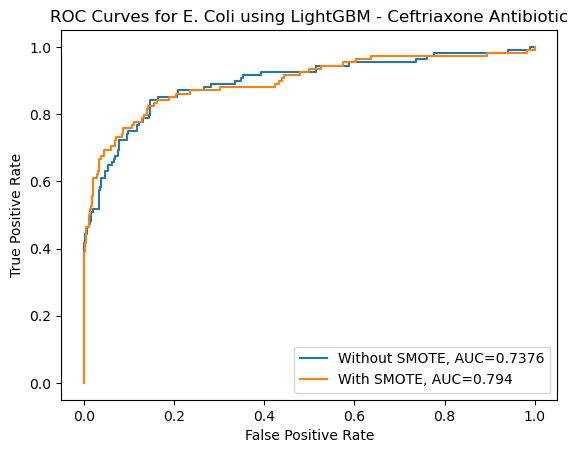

In [12]:
fpr_regular, tpr_regular, thresholds = roc_curve(ceftriaxone_y_test, regular_lightgbm.predict_proba(ceftriaxone_X_test)[:, 1], pos_label=1)
auc = round(roc_auc_score(ceftriaxone_y_test, ceftriaxone_y_pred), 4)
plt.plot(fpr_regular, tpr_regular, label="Without SMOTE, AUC=" + str(auc))

fpr_smote, tpr_smote, thresholds = roc_curve(ceftriaxone_y_test, smote_lightgbm.predict_proba(ceftriaxone_X_test)[:, 1], pos_label=1)
auc = round(roc_auc_score(ceftriaxone_y_test, ceftriaxone_y_pred_resampled), 4)
plt.plot(fpr_smote, tpr_smote, label="With SMOTE, AUC=" + str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for E. Coli using LightGBM - Ceftriaxone Antibiotic")
plt.legend(loc = "lower right")